In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gitcode import all_functions as funcs
import os

### Simulation parameters for a dummy network scenario

In [15]:
network_params = {"realizations": 200  # small scale realizations  (Critical : should be a large value if large number APs and UEs are used)
                    , "delta_h": 11 # height difference
                    , "area": 500  # lxl Service Area
                    , "bandwidth": 100e6
                    , "L": 20  # APs
                    , "N": 3  # antennas per AP
                    , "K": 5  # UEs
                    , "tau_c": 200 # total samples in coherence block
                    , "tau_p": 4  # samples for pilots
                    , "p_k": 100  # uplink power (mW)
                    , "uplink_variance_dbm": -94 # Receiver noise power (dBm)
                    , "carrier_frequency": 5000  # carrier frequency (MHz)
                    , "sigma_sf_los": 8  # Shadow fading LoS (dB)
                                     }

### Experiment Parameters

- **`setups`**: Specifies the number of Monte-Carlo simulations per experiment.

- **`batch`**: Controls the trade-off between **space complexity** and **runtime**.
    - **`batch = realizations`**: Computations are performed simultaneously over all realizations in vectorized form.
    - **`batch = 1`**: Computations are performed iteratively for each realization individually.

- **Fractional Power Control (`v`)**:
    - **`v = -1`**: Implements an approximation of **max-min SE fairness**.
    - **`v = 0`**: Implements an approximation of **sum-power optimization**.

- **`kappa_list = [0, 5]`**:
  The same network setup is simulated for:
    - **Figure 7a**: with **k-factor = [0,1,5,20,100]** and **v=-1**
    - **Figure 7b**: with **k-factor = [0,1,5,20,100]** and **v=0**

In [16]:
setups=10
batch=200
v=-1
kappa_list = [0,5]

In [29]:
results_path=os.getcwd()+"/Results/"
if not os.path.exists(results_path):
    os.makedirs(results_path)
else:
    print(f"Folder already exists")

Folder already exists


In [18]:
for i in range(0,setups):
    np.random.seed(i)
    p_max=network_params["p_k"]

    # A network setup is generated, distances and spatial correlation matrices are calculated
    R_spatial_corr_norm, B_channel_gain, HMean_norm, k_rician_factor = funcs.simulation_area(network_params)

    # Cooperation clusters formation and pilot assignment
    D_cellular, D_DCC, pilot_indicies = funcs.initial_access(network_params,B_channel_gain)

    for d in kappa_list:
        # for same network setup , k-factor for all channels is set equal to 0 and in next iteration to 5 to cover both cases.
        k_rician_factor[:]=d

        # Generate random channels, channel mean(los component) and spatial correlation matrix
        H, HMean, R_spatial_corr = funcs.channel_generation(network_params, R_spatial_corr_norm,HMean_norm,k_rician_factor)

        # Estimate channels using MMSE estimator  (CSI is obtained)
        H_hat = funcs.channel_estimation(network_params, R_spatial_corr, pilot_indicies, H,
                                                           HMean, p_max)

        #reshaping
        H = np.moveaxis(H, -1, 0)
        H_hat = np.moveaxis(H_hat, -1, 0)
        H = np.swapaxes(H, 2, 3)
        H_hat = np.swapaxes(H_hat, 2, 3)
        K=network_params["K"]

        ## For Cellfree with DCC
        # re-assigning uplink transmit power to each UE in cell-free network after pilots are received, using eq 44
        sum_B_il = np.zeros(K)
        for k in range(0, K):
            servingAP = np.asarray(np.where(D_DCC[:, k] == 1)).reshape(-1)
            sum_B_il[k] = np.sum(funcs.db2pow(B_channel_gain[servingAP, k]))
        p_k = p_max * sum_B_il ** v / np.max(sum_B_il ** v)  # Kx1 vector power for all UEs

        #Calculating and saving SE using centralized MMSE beamforming
        SE = funcs.compute_SE_MMSE(network_params, p_k, D_DCC, H_hat, H, batch)
        with open(results_path + 'SE_MMSE_DCC_' + str(i) + '_' + str(d) + '.npy',
                  'wb') as f:
            np.save(f, SE)

        #Calculating and saving SE using distributed Local-MMSE beamforming
        SE = funcs.compute_SE_LMMSE(network_params, p_k, D_DCC, H_hat, H, batch)
        with open(results_path + 'SE_LMMSE_DCC_' + str(i) + '_' + str(d) + '.npy',
                  'wb') as f:
            np.save(f, SE)

        #Calculating and saving SE using distributed Team-MMSE beamforming
        SE = funcs.compute_SE_TMMSE(network_params, p_k, D_DCC, H_hat, H, batch)
        with open(results_path + 'SE_TMMSE_DCC_' + str(i) + '_' + str(d) + '.npy', 'wb') as f:
            np.save(f, SE)


C:\Users\ain\Documents\Thesis\ThesisCode\gitcode\all_functions.py:552: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  R = linalg.toeplitz(spatial_corr_UE)  # integral gives Nx1, we need to calculate NxN matrix from it


### Reading saved data and plotting the results

In [19]:
kappa = np.array(kappa_list).astype(str)
mmse_k_dcc_mm, lmmse_k_dcc_mm, tmmse_k_dcc_mm = funcs.read_SEs_dist_(results_path, K, kappa, setups,"DCC")

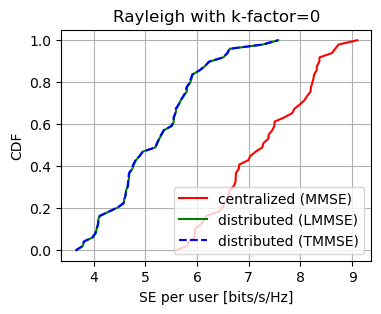

In [26]:
y=np.linspace(0,1,len(mmse_k_dcc_mm[0,:,:].flatten()))
plt.figure(figsize=(4, 3))
plt.plot(np.sort(mmse_k_dcc_mm[0,:,:].flatten()),y, color="red", label="centralized (MMSE)")
plt.plot(np.sort(lmmse_k_dcc_mm[0,:,:].flatten()),y, color="green", label="distributed (LMMSE)")
plt.plot(np.sort(tmmse_k_dcc_mm[0,:,:].flatten()),y,'--', color="blue", label="distributed (TMMSE)")

plt.ylabel('CDF')
plt.xlabel('SE per user [bits/s/Hz]')
plt.grid()
# plt.xlim(0,10)
plt.legend(loc=4, prop={'size': 10})
plt.title("Rayleigh with k-factor=0")
plt.savefig(bbox_inches='tight',fname=results_path+'fig_k0.png')

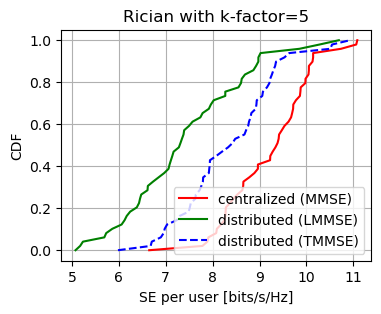

In [27]:
y=np.linspace(0,1,len(mmse_k_dcc_mm[0,:,:].flatten()))
plt.figure(figsize=(4, 3))
plt.plot(np.sort(mmse_k_dcc_mm[1,:,:].flatten()),y, color="red", label="centralized (MMSE)")
plt.plot(np.sort(lmmse_k_dcc_mm[1,:,:].flatten()),y, color="green", label="distributed (LMMSE)")
plt.plot(np.sort(tmmse_k_dcc_mm[1,:,:].flatten()),y,'--', color="blue", label="distributed (TMMSE)")
plt.ylabel('CDF')
plt.xlabel('SE per user [bits/s/Hz]')
plt.grid()
# plt.xlim(0,10)
plt.legend(loc=4, prop={'size': 10})
plt.title("Rician with k-factor=5")
plt.savefig(bbox_inches='tight',fname=results_path+'fig_k5.png')